<a href="https://colab.research.google.com/github/Anth-us/semantic-text-classification/blob/main/Custom_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Using Logistic Regression and Vector Embeddings

### Objective
This notebook aims to develop and evaluate a logistic regression model for classifying sentences. The model will identify whether a sentence is related to the Spanish immigration system.

### Methodology
- We utilize vector embeddings obtained from the OpenAI Ada 2 model.
- A logistic regression approach is employed for the classification task.

### Data
- The dataset comprises synthetic sentences, some related to Spanish immigration and others not.
- We split the data into training and evaluation sets for a robust assessment.

### Evaluation
- The model's performance is evaluated using metrics such as accuracy, precision, recall, and F1-score.
- A confusion matrix will provide insights into the model's classification capabilities.

### Visualization
- The notebook will feature visualizations, including static plots and dynamic animations, to illustrate the training and evaluation process.

## Import necessary libraries

In [15]:
!pip install gensim
!pip install openai

In [17]:
import json
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from google.colab import userdata

## Generate the embeddings

We'll convert each sentence in our dataset into a vector embedding. We'll load our initial CSV file, which contains sentences and their associated labels, we'll compute an embedding for each sentence, and we'll store that back to a CSV file that includes the label, sentence and embedding.  We'll do that in a few different ways.

### Word2Vec

In [55]:
# Load the CSV containing labeled sentences.
df = pd.read_csv('labeled.csv')

# Check if the DataFrame is not empty
print(f"Number of sentences: {len(df)}")

# Prepare sentences for Word2Vec
sentences = [sentence.split() for sentence in df['sentence']]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=150, window=5, min_count=1, workers=4)

# Initialize a counter
counter = 0

# Function to generate sentence embedding by averaging word embeddings
def sentence_embedding(sentence):
    global counter

    words = sentence.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    sentence_emb = np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

    # Convert array to JSON string
    sentence_emb_json = json.dumps(sentence_emb.tolist())

    # Print only for the first 10 sentences
    if counter < 10:
        print("Embedding: ", sentence_emb_json)
    elif counter == 10:
        print("Continuing to process, but not printing the rest...")

    counter += 1
    return sentence_emb_json

# Generate embeddings
df['embedding'] = df['sentence'].apply(sentence_embedding)

# Save to new CSV
df.to_csv('Word2Vec.csv', index=False)

Number of sentences: 1195
Embedding:  [0.10625797510147095, -0.017959903925657272, -0.021647226065397263, -0.10849887132644653, -0.019402042031288147, -0.24687369167804718, -0.03763056918978691, 0.4713030755519867, -0.09666352719068527, 0.08148175477981567, 0.10132038593292236, -0.04523833841085434, -0.2734445035457611, 0.35596802830696106, -0.190166175365448, -0.020542258396744728, 0.23407313227653503, 0.15646736323833466, -0.026768755167722702, 0.08354883641004562, -0.1443103849887848, -0.03883611410856247, 0.11347254365682602, 0.29571518301963806, -0.023247970268130302, -0.00026132864877581596, -0.25094547867774963, -0.059886157512664795, 0.027164176106452942, -0.28997913002967834, 0.04959151893854141, 0.029132341966032982, 0.013292203657329082, 0.05054444074630737, -0.15868037939071655, 0.09201185405254364, 0.4355507791042328, 0.010040664114058018, 0.021442808210849762, -0.18332362174987793, -0.042371537536382675, 0.10973767936229706, -0.07209266722202301, -0.10411075502634048, 0.0

## BERT

In [56]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embedding(sentence):
    global counter

    # Tokenize and encode the sentence
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the mean of the last hidden state as the sentence embedding
    sentence_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    # Convert array to JSON string
    sentence_emb_json = json.dumps(sentence_emb.tolist())

    if counter < 10:
        print("Embedding: ", sentence_emb_json)
    elif counter == 10:
        print("Continuing to process, but not printing the rest...")

    counter += 1
    return sentence_emb_json

# Load the CSV containing labeled sentences
df = pd.read_csv('labeled.csv')

# Reset counter
counter = 0

# Generate embeddings
df['embedding'] = df['sentence'].apply(bert_embedding)

# Save to new CSV
df.to_csv('BERT.csv', index=False)


Embedding:  [-0.23313181102275848, -0.30737432837486267, -0.17015017569065094, 0.12677490711212158, 0.6584125757217407, 0.2631322741508484, 0.14025580883026123, 1.3568280935287476, 0.16707292199134827, -0.2427053153514862, -0.1555050015449524, -0.24177873134613037, -0.09613368660211563, 0.16425980627536774, -0.19912798702716827, 1.1140857934951782, 0.6899012327194214, -0.08486225455999374, -0.48404189944267273, 0.10067449510097504, 0.2901366949081421, -0.41568779945373535, -0.004370814189314842, 0.09828056395053864, -0.2090129852294922, -0.5960085391998291, -0.27324527502059937, 0.24805618822574615, -0.3375166356563568, -0.1054101437330246, -0.088280588388443, -0.12534384429454803, -0.8349630236625671, -0.10627224296331406, 0.43717846274375916, 0.40268784761428833, 0.055624376982450485, -0.5566353797912598, -0.1431456208229065, 0.3612031936645508, -0.8249363899230957, -0.22906775772571564, -0.42001792788505554, 0.006165876053273678, -0.2771264314651489, -0.15688566863536835, 0.33307048

### OpenAI Ada 2

In [57]:
client = OpenAI(api_key=userdata.get('openai'))

# Initialize a counter
counter = 0

# Function to get embeddings from OpenAI
def get_embedding(sentence):
    global counter
    try:
        response = client.embeddings.create(
            model="text-embedding-ada-002",
            input=sentence
        )

        # Extract the embedding and convert it to JSON string
        embedding = response.model_dump()['data'][0]['embedding']

        # Print only for the first 10 sentences
        if counter < 10:
            print("Embedding: ", embedding)
        elif counter == 10:
            print("Continuing to process, but not printing the rest...")

        counter += 1
        return json.dumps(embedding)
    except Exception as e:
        print(f"Error in processing sentence: '{sentence}'. Error: {e}")
        return None  # or a default embedding

# Generate embeddings for each sentence
df['embedding'] = df['sentence'].apply(get_embedding)

# Save to new CSV
df.to_csv('openai-ada-2-embeddings.csv', index=False)


Embedding:  [0.019655795767903328, -0.004800185561180115, 0.03021051734685898, -0.020452139899134636, -0.03177792578935623, 0.0014710245886817575, -0.025799022987484932, -0.00022792191884946078, -0.020907195284962654, -0.022525163367390633, 0.01030191220343113, 0.0025944386143237352, 0.01252662017941475, 0.02024989388883114, -0.005365842953324318, 0.013133358210325241, 0.026039190590381622, -0.023966167122125626, 0.058297447860240936, -0.0012166369706392288, -0.03385094553232193, 0.007691673468798399, -0.01629345491528511, -0.005545968189835548, 0.00914531759917736, 0.0016369296936318278, 0.018101029098033905, -0.008709223940968513, -0.004541057627648115, -0.01969371736049652, 0.033092524856328964, -0.0006035782862454653, -0.0003509681555442512, 0.0013943923404440284, -0.022891733795404434, -0.005015071947127581, -0.009789977222681046, -0.01593952439725399, 0.017292045056819916, -0.001750693074427545, 0.02471194975078106, 0.02659536711871624, -0.005836697295308113, 0.002482255222275853

## Load and Preprocess Data

Assume you have a DataFrame df with two columns: sentence (text data) and label (0 or 1, indicating whether the sentence is about Spanish immigration).

In [46]:
# List of filenames for different embedding CSVs
filenames = [
    'Word2Vec.csv',
    'BERT.csv',
    'OpenAI Ada 2.csv'
  ]

def prepare_data(filename):
    df = pd.read_csv(filename)
    X, y = [], []

    for idx, row in df.iterrows():
        try:
            # Convert string to list if necessary
            embedding = json.loads(row['embedding']) if isinstance(row['embedding'], str) else row['embedding']
            X.append(embedding)
            y.append(row['label'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in row {idx} of file {filename}: {e}")
            print(f"Faulty data: {row['embedding']}")
        except Exception as e:
            print(f"Unexpected error in row {idx} of file {filename}: {e}")

    return np.array(X), np.array(y)

# Dictionary to store the X and y for each embedding type
data_for_embeddings = {}

for filename in filenames:
    print(f"Processing file: {filename}")
    X, y = prepare_data(filename)
    data_for_embeddings[filename] = (X, y)
    print(f"Completed processing file: {filename}\n")

Processing file: Word2Vec.csv
Completed processing file: Word2Vec.csv

Processing file: BERT.csv
Completed processing file: BERT.csv

Processing file: OpenAI Ada 2.csv
Completed processing file: OpenAI Ada 2.csv



## Split Data into Training and Testing Sets

In [47]:
# Dictionary to store train-test splits for each embedding type
train_test_splits = {}

for filename, (X, y) in data_for_embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_test_splits[filename] = (X_train, X_test, y_train, y_test)
    print(f"Completed train-test split for file: {filename}")


Completed train-test split for file: Word2Vec.csv
Completed train-test split for file: BERT.csv
Completed train-test split for file: OpenAI Ada 2.csv


## Train Logistic Regression Model

In [48]:
# Dictionary to store models for each embedding type
models = {}

for filename, (X_train, X_test, y_train, y_test) in train_test_splits.items():
    model = LogisticRegression()
    model.fit(X_train, y_train)
    models[filename] = model
    print(f"Trained logistic regression model for file: {filename}")

Trained logistic regression model for file: Word2Vec.csv
Trained logistic regression model for file: BERT.csv
Trained logistic regression model for file: OpenAI Ada 2.csv


## Evaluate the Models

In [51]:
metrics = {}

# Iterate over each embedding type to evaluate the models
for filename, model in models.items():
    X_train, X_test, y_train, y_test = train_test_splits[filename]

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    metrics[filename] = {'accuracy': accuracy, 'precision': precision, 'recall': recall}

    # Print the results
    print(f"Results for file: {filename}")
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Now populate the lists for plotting
filenames = list(metrics.keys())
accuracies = [metrics[file]['accuracy'] for file in filenames]
precisions = [metrics[file]['precision'] for file in filenames]
recalls = [metrics[file]['recall'] for file in filenames]


Results for file: Word2Vec.csv
Accuracy: 0.9623430962343096

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       113
           1       1.00      0.93      0.96       126

    accuracy                           0.96       239
   macro avg       0.96      0.96      0.96       239
weighted avg       0.97      0.96      0.96       239

Results for file: BERT.csv
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       126

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239

Results for file: OpenAI Ada 2.csv
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1

## Visualize Key Metrics

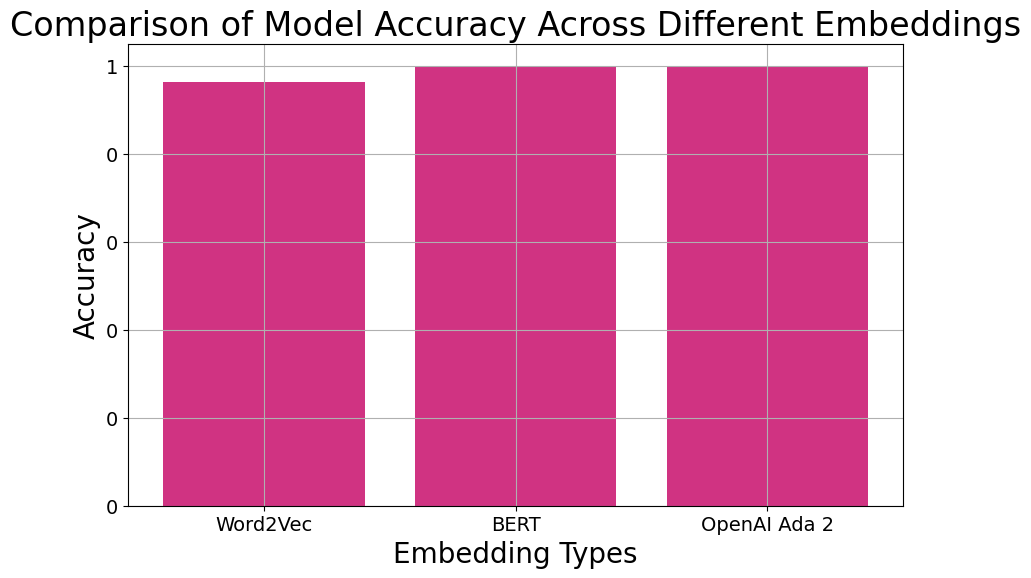

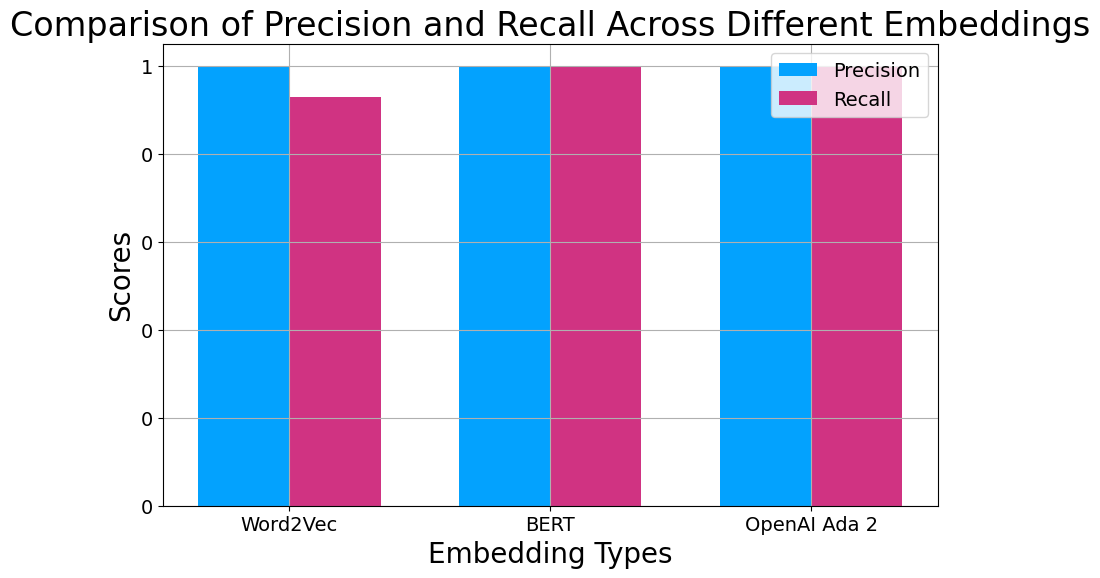

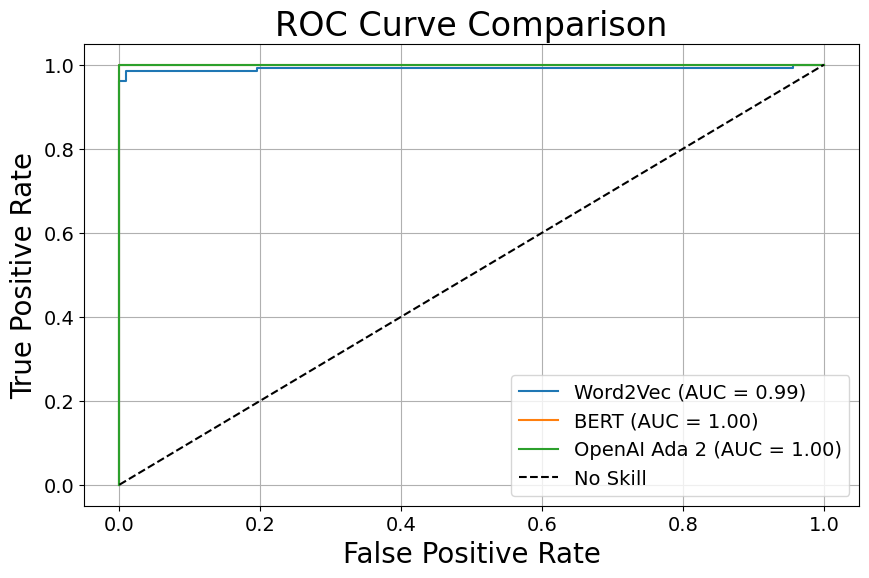

In [53]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format the tick labels with commas
def comma_formatter(x, pos):
    return '{:,}'.format(int(x))

# Remove '.csv' from filenames for plot labels
plot_labels = [filename.replace('.csv', '') for filename in filenames]

# Metrics visualization
plt.figure(figsize=(10, 6))
plt.bar(plot_labels, accuracies, color=(0.815, 0.2, 0.51))
plt.xlabel('Embedding Types', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Comparison of Model Accuracy Across Different Embeddings', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.grid(True)
plt.show()

# Precision and Recall visualization
plt.figure(figsize=(10, 6))
width = 0.35
indices = np.arange(len(plot_labels))

# Using blue for precision and fuchsia for recall
plt.bar(indices - width/2, precisions, width, label='Precision', color=(0.012, 0.635, 0.996))
plt.bar(indices + width/2, recalls, width, label='Recall', color=(0.815, 0.2, 0.51))
plt.xlabel('Embedding Types', fontsize=20)
plt.ylabel('Scores', fontsize=20)
plt.title('Comparison of Precision and Recall Across Different Embeddings', fontsize=24)
plt.xticks(indices, plot_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.grid(True)
plt.show()

# ROC Curve visualization
plt.figure(figsize=(10, 6))

for filename, model in models.items():
    X_train, X_test, y_train, y_test = train_test_splits[filename]
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{filename.replace(".csv", "")} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve Comparison', fontsize=24)
plt.legend(loc='lower right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()


## Visualize the Confusion Matrix

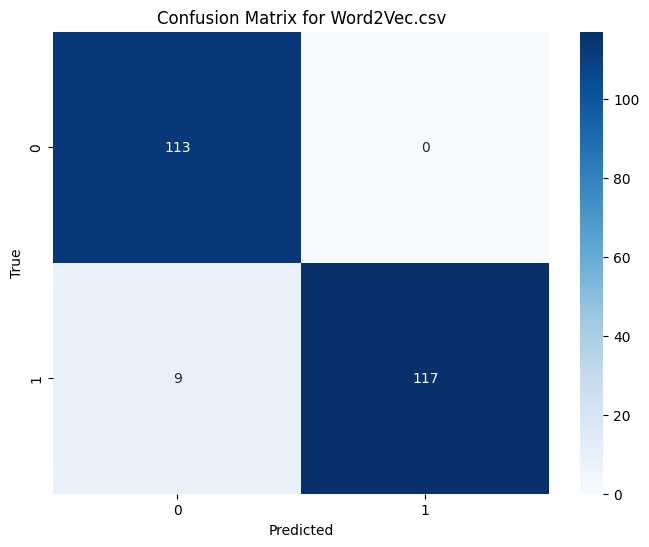

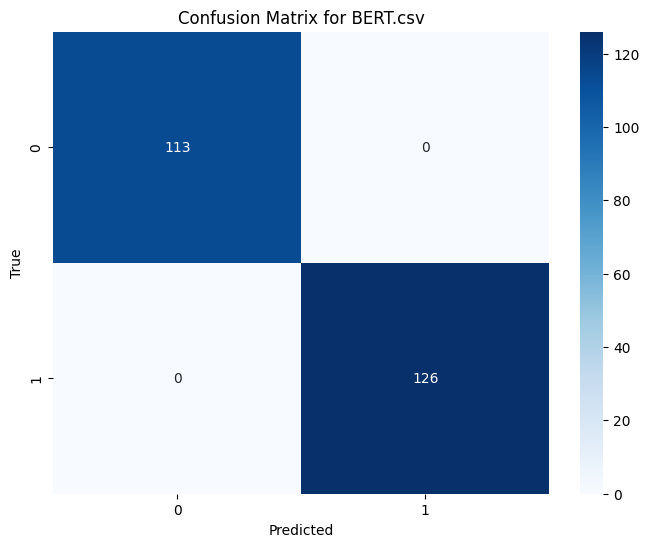

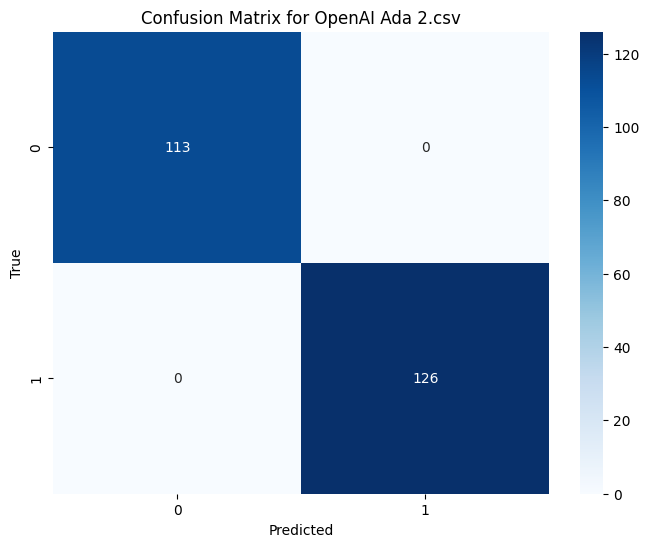

In [54]:
for filename, model in models.items():
    X_train, X_test, y_train, y_test = train_test_splits[filename]

    # Predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {filename}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()